# City of Cape Town - Property Valuation Tool

### Imports

In [31]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline

## Data Pre-processing and cleaning

In [32]:
#load json object
with open('capetown_2022.txt') as f:
    data = json.load(f)

In [33]:
data

[{'id': 'P110999173',
  'price': 'R 25 950 000',
  'location': 'Zwaanswyk',
  'address': '92 Zwaanswyk Road',
  'size': '11 910 m²',
  'property_type': 'Farm'},
 {'id': 'P111316089',
  'price': 'R 2 245 000',
  'location': 'Green Point',
  'address': None,
  'size': '56 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1',
  'Parking Spaces': '1'},
 {'id': 'P110566416',
  'price': 'R 1 880 000',
  'location': 'Cape Town City Centre',
  'address': None,
  'size': '37 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1'},
 {'id': 'P109398856',
  'price': 'R 7 800 000',
  'location': 'Green Point',
  'address': None,
  'size': '412 m²',
  'property_type': 'House',
  'Bedrooms': '3',
  'Bathrooms': '3.5',
  'Parking Spaces': '4'},
 {'id': 'P110242601',
  'price': 'R 10 750 000',
  'location': 'Waterfront',
  'address': None,
  'size': '105 m²',
  'property_type': 'Apartment',
  'Bedrooms': '2',
  'Bathrooms': '2',
  'Parking Spaces': '2'},
 {'id'

In [34]:
# get data into pandas dataframe
ct_data = pd.json_normalize(data=data) 
ct_data.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
0,P110999173,R 25 950 000,Zwaanswyk,92 Zwaanswyk Road,11 910 m²,Farm,NaN,NaN,NaN
1,P111316089,R 2 245 000,Green Point,None,56 m²,Apartment,1,1,1
2,P110566416,R 1 880 000,Cape Town City Centre,None,37 m²,Apartment,1,1,NaN
3,P109398856,R 7 800 000,Green Point,None,412 m²,House,3,3.5,4
4,P110242601,R 10 750 000,Waterfront,None,105 m²,Apartment,2,2,2


Looking at the data, there are a few things that need to be done. Property types such as farms, vacant land etc. need to be removed. For the purposes of this model, only property types such as apartments and houses will be considered.
The units need to be removed from the size column, and the 'R' needs to be removed from price.

In [35]:
#Removing vacant land, commercial and industrial properties
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Vacant Land'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Commercial Property'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Industrial Property'], inplace = True)
ct_data.drop(ct_data.index[ct_data['property_type'] == 'Farm'], inplace = True)

# Remove 'R' and whitespace from price
ct_data['price'] = ct_data['price'].str.replace(r"[a-zA-Z]",'', regex=True)
ct_data['price'] = ct_data['price'].str.replace(' ', '', regex= True)

#Remove m2 from size
ct_data['size'] = ct_data['size'].str.replace(r'\D', '', regex=True)

ct_data.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
1,P111316089,2245000,Green Point,None,56,Apartment,1,1,1
2,P110566416,1880000,Cape Town City Centre,None,37,Apartment,1,1,NaN
3,P109398856,7800000,Green Point,None,412,House,3,3.5,4
4,P110242601,10750000,Waterfront,None,105,Apartment,2,2,2
5,P111185032,3450000,Wynberg Upper,None,241,House,1,1,1


In [36]:
# Taking a look at the data types of eacch column
ct_data.dtypes

id                object
price             object
location          object
address           object
size              object
property_type     object
Bedrooms          object
Bathrooms         object
Parking Spaces    object
dtype: object

Variables such as price, size, bedrooms, bathrooms and parking spaces have to be converted into numeric datatypes

In [37]:
#convert to numeric\
ct_data['price'] = pd.to_numeric(ct_data['price'])
ct_data['size'] = pd.to_numeric(ct_data['size'])
ct_data['Bedrooms'] = pd.to_numeric(ct_data['Bedrooms'])
ct_data['Bathrooms'] = pd.to_numeric(ct_data['Bathrooms'])
ct_data['Parking Spaces'] = pd.to_numeric(ct_data['Parking Spaces'])

ct_data.dtypes

id                 object
price             float64
location           object
address            object
size              float64
property_type      object
Bedrooms          float64
Bathrooms         float64
Parking Spaces    float64
dtype: object

In [38]:
#Taking a look at the number of rows
ct_data.count() # show us the number of rows

id                8644
price             8597
location          8644
address           3283
size              8056
property_type     8644
Bedrooms          8364
Bathrooms         8543
Parking Spaces    7219
dtype: int64

This suggests that there may be some missing data or nulls in the dataset.
The next steps will be to check what the number of nulls in each column are, and then try and replace the missing data using imputation 

In [39]:
ct_data.isnull().sum()

id                   0
price               47
location             0
address           5361
size               588
property_type        0
Bedrooms           280
Bathrooms          101
Parking Spaces    1425
dtype: int64

The important variables to try and impute would be price, size, number of bedrooms, bathrooms and parking spaces. <br>
The next step is to look at the summary statistics of the data and then decide on the best measure to use for imputing values


In [40]:
# Taking a look at some descriptive statistics
ct_data.describe() 

,price,size,Bedrooms,Bathrooms,Parking Spaces
count,8.597000e+03,8056.000000,8364.000000,8543.000000,7219.000000
mean,5.303907e+06,344.455189,2.533238,1.980306,2.222053
std,8.906688e+06,1720.465383,1.762869,1.537634,1.937960
min,2.000000e+05,13.000000,0.500000,0.500000,0.500000
25%,1.650000e+06,62.000000,2.000000,1.000000,1.000000
50%,2.600000e+06,105.500000,2.000000,2.000000,2.000000
75%,5.000000e+06,309.250000,3.000000,2.000000,2.000000
max,2.300000e+08,125762.000000,47.000000,45.000000,26.000000


In [41]:
ct_data.groupby(['Bedrooms'])['price'].median()

Bedrooms
0.5      1495000.0
1.0      1850000.0
1.5      1950000.0
2.0      2500000.0
2.5      1895000.0
3.0      3495000.0
3.5      6895000.0
4.0      6900000.0
4.5      5715000.0
5.0      8695000.0
5.5      1850000.0
6.0      9200000.0
7.0     15250000.0
8.0     10500000.0
9.0      9400000.0
10.0     7245000.0
11.0     8999000.0
12.0    11995000.0
13.0    18475000.0
14.0    12872500.0
15.0     8500000.0
16.0     8900000.0
17.0     3850000.0
18.0    14700000.0
19.0    41990000.0
21.0     6995000.0
28.0    13200000.0
30.0    39500000.0
47.0           NaN
Name: price, dtype: float64

In [43]:
ct_data.groupby(['Bathrooms'])['price'].median()

Bathrooms
0.50      1979000.0
1.00      1695000.0
1.25      2250000.0
1.50      2495000.0
2.00      3500000.0
2.50      6750000.0
3.00      5875000.0
3.50     10500000.0
4.00      9000000.0
4.50     17500000.0
5.00     14500000.0
5.50     24950000.0
6.00     18844500.0
6.50     28200000.0
7.00     18622500.0
7.50     35000000.0
8.00     17500000.0
8.50     23500000.0
9.00     20250000.0
9.50     56000000.0
10.00    12850000.0
11.00    13847500.0
12.00    11000000.0
12.50    28000000.0
13.00    43500000.0
14.00    14075000.0
16.00    15500000.0
16.50    25000000.0
18.00    14700000.0
19.50    41990000.0
30.00    39500000.0
45.00           NaN
Name: price, dtype: float64

In [44]:
ct_data.groupby(['Parking Spaces'])['price'].median()

Parking Spaces
0.5      1210000.0
1.0      1995000.0
1.5      4995000.0
2.0      4450000.0
2.5      2995000.0
3.0      3995000.0
4.0      6500000.0
4.5      2350000.0
5.0      3695000.0
6.0      4795000.0
7.0      6995000.0
8.0      7495000.0
9.0      8347500.0
10.0     8825000.0
11.0    24475000.0
12.0    18500000.0
13.0    23000000.0
14.0    71500000.0
15.0     9000000.0
16.0    15650000.0
17.0    17423999.5
18.0    11250000.0
20.0     1199000.0
26.0     7923000.0
Name: price, dtype: float64

In [45]:
ct_data.groupby(['size'])['price'].mean()

size
13.0        1.495000e+06
14.0        6.500000e+05
17.0        4.500000e+05
19.0        8.949998e+05
20.0        5.463333e+05
                ...     
17587.0     2.500000e+07
24671.0     6.500000e+07
37035.0     6.495000e+06
39243.0     1.600000e+07
125762.0    8.750000e+06
Name: price, Length: 1118, dtype: float64

Outliers need to be detected and possibly removed

<AxesSubplot:xlabel='price'>

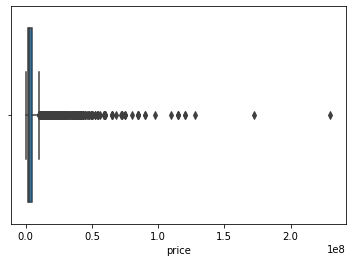

In [46]:
sns.boxplot(x=ct_data['price'])

<AxesSubplot:xlabel='size'>

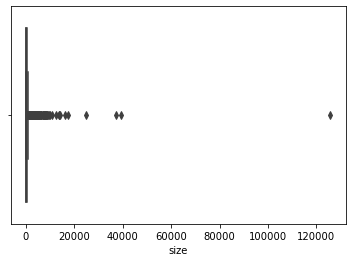

In [47]:
sns.boxplot(x=ct_data['size'])

<AxesSubplot:xlabel='Bedrooms'>

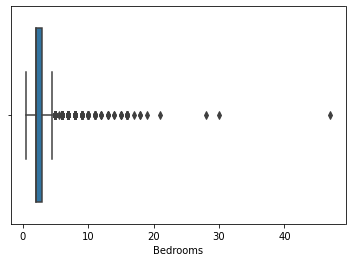

In [49]:
sns.boxplot(x=ct_data['Bedrooms'])

<AxesSubplot:xlabel='Bathrooms'>

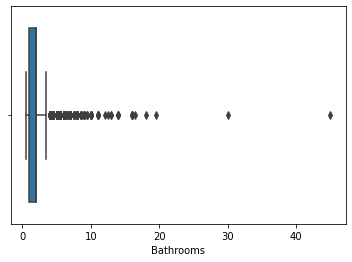

In [50]:
sns.boxplot(x=ct_data['Bathrooms'])

<AxesSubplot:xlabel='Parking Spaces'>

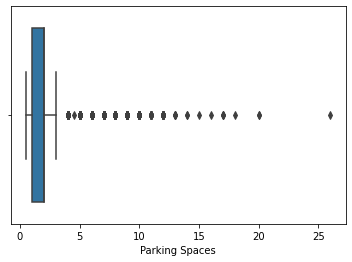

In [51]:
sns.boxplot(x=ct_data['Parking Spaces'])

In [ ]:
#Encoding categorical features such as location and property type


In [52]:
#Function to get rid of outliers
def get_outliers(X, outliers_fraction=0.25):
    clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
    clf.fit(X)
    result = clf.predict(X)
    return result

In [53]:
ct_data2 = ct_data[get_outliers(ct_data.drop(columns=['id']), 0.15)==1]
ct_data2.describe()

ValueError: could not convert string to float: 'Green Point'